# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

import json




import json
import datetime
import skimage.draw


# Root directory of the project
#ROOT_DIR = os.path.abspath("../../")
# define abosolute path
ROOT_DIR = "/home/donchan/Documents/Miyuki/Mask_RCNN"

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils


# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    print("load mdodel")
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


## For Custom data set 

In [2]:
from samples.miyukiCamera import miyukiCamera

## Configurations

In [3]:
# miyuki camera config 

DATA_DIR = "/home/donchan/Documents/Miyuki/MaskRCNN_data/datasets/miyukiCamera"

config = miyukiCamera.MiyukiCameraConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                25
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [4]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [5]:
class MiyukiCameraDataset(utils.Dataset):

    def load_classObjects(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("miyukiCamera", 1, "drug")
        self.add_class("miyukiCamera", 2, "prescription")
        self.add_class("miyukiCamera", 3, "hands")
        self.add_class("miyukiCamera", 4, "sheets")
        self.add_class("miyukiCamera", 5, "money")
        self.add_class("miyukiCamera", 6, "cointab")
        self.add_class("miyukiCamera", 7, "hair")
        
        self.add_class("miyukiCamera", 8, "documents")
        self.add_class("miyukiCamera", 9, "notes")
        self.add_class("miyukiCamera", 10, "envelope")
        self.add_class("miyukiCamera", 11, "insurance")
        self.add_class("miyukiCamera", 12, "receipt")
        
        
        
        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
        print(dataset_dir)


        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            
            #polygons = [r['shape_attributes'] for r in a['regions'].values()]
            objects = [r['region_attributes'] for r in a['regions'].values()]

            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 



            #print("class objects polygons : ", polygons)

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "miyukiCamera",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                objects=objects)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.

        image_info = {
            "id": image_id,
            "source": source,
            "path": path,
        }
        """
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        print("## image info source ", image_info["source"])
        if image_info["source"] != "miyukiCamera":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]

        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8) # Generate the numbers of mask
        
        
        polygons_objects_id = []
        for i, p in enumerate(info["polygons"]):

            #############
            #              IMPORTANT 
            ############# 
            if p["name"] != "polygon":
                # if rect, skipped process to escape error from all_points_x/all_points_y
                continue
            #############
            #               
            ############# 


            #print("# index #", i, p["name"])
            #print(p)

            #
            #  keep only polygons object id from polygons json data..
            #
            polygons_objects_id.append(i)
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        names = []
        for i, a in enumerate( info["objects"] ):
            
            if i in polygons_objects_id:
                names.append(a["classification"])
                #print("info object of image_info : ", a)
            #else: 
            #    print("info object is NOT polygons --> %s " %  a["classification"]  )


        class_ids = np.array([self.class_names.index(n) for n in names])
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        #return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
        return mask.astype(np.bool), class_ids.astype(np.int32)



    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "miyukiCamera":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


In [6]:
# Training dataset
#dataset_train = ShapesDataset()
#dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
#dataset_train.prepare()

# Validation dataset
#dataset_val = ShapesDataset()
#dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
#dataset_val.prepare()



"""Train the model."""
# Training dataset.
dataset_train = MiyukiCameraDataset()
dataset_train.load_classObjects(DATA_DIR, "train")
dataset_train.prepare()

# Validation dataset
dataset_val = MiyukiCameraDataset()
dataset_val.load_classObjects(DATA_DIR, "val")
dataset_val.prepare()


/home/donchan/Documents/Miyuki/MaskRCNN_data/datasets/miyukiCamera/train
/home/donchan/Documents/Miyuki/MaskRCNN_data/datasets/miyukiCamera/val


In [13]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    #image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    #visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [332, 249, 833, 907, 538, 420, 332], 'all_points_y': [38, 701, 694, 81, 31, 32, 38]}
# index # 1 polygon
{'name': 'polygon', 'all_points_x': [1219, 952, 926, 943, 969, 994, 1019, 1224, 1219], 'all_points_y': [35, 34, 579, 624, 672, 690, 712, 710, 35]}
info object of image_info :  {'classification': 'prescription'}
info object of image_info :  {'classification': 'cointab'}
## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [443, 427, 1150, 1184, 443], 'all_points_y': [120, 637, 646, 139, 120]}
# index # 1 polygon
{'name': 'polygon', 'all_points_x': [597, 582, 1101, 1110, 597], 'all_points_y': [39, 109, 128, 36, 39]}
# index # 2 polygon
{'name': 'polygon', 'all_points_x': [4, 408, 391, 2, 4], 'all_points_y': [35, 38, 697, 684, 35]}
info object of image_info :  {'classification': 'receipt'}
info object of image_info :  {'classification': 'drug'}
info object of

## Ceate Model

In [8]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [9]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [10]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/donchan/Documents/Miyuki/Mask_RCNN/logs/miyukicamera20181218T2147/mask_rcnn_miyukicamera_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4    

/home/donchan/anaconda37/envs/py36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/donchan/anaconda37/envs/py36/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
## image info source  miyukiCamera
# index # 0 polygon
## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [5, 8, 229, 206, 205, 248, 285, 259, 348, 398, 5], 'all_points_y': [56, 609, 629, 547, 497, 481, 532, 413, 386, 56, 56]}
{'name': 'polygon', 'all_points_x': [5, 8, 229, 206, 205, 248, 285, 259, 348, 398, 5], 'all_points_y': [56, 609, 629, 547, 497, 481, 532, 413, 386, 56, 56]}
## image info source  miyukiCamera
## image info source  miyukiCamera
## image info source  miyukiCamera
## image info source  miyukiCamera
## image info source  miyukiCamera
# index # 0 polygon
# index # 0 polygon
## image info source  miyukiCamera
# index # 0 polygon
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [5, 8, 229, 206, 205, 248, 285, 259, 348, 398, 5], 'all_points_y': [56, 609, 629, 547, 497, 481, 532, 413, 386, 56, 56]}
# index # 0 polygon
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [5, 8, 229, 206, 205, 248, 285, 259, 348, 3

{'name': 'polygon', 'all_points_x': [747, 721, 858, 882, 747], 'all_points_y': [310, 655, 666, 298, 310]}
info object of image_info :  {'classification': 'drug'}
# index # 1 polygon
# index # 1 polygon
info object of image_info :  {'classification': 'hands'}
{'name': 'polygon', 'all_points_x': [747, 721, 858, 882, 747], 'all_points_y': [310, 655, 666, 298, 310]}
{'name': 'polygon', 'all_points_x': [747, 721, 858, 882, 747], 'all_points_y': [310, 655, 666, 298, 310]}
# index # 2 polygon
# index # 2 polygon
{'name': 'polygon', 'all_points_x': [282, 187, 237, 265, 373, 253, 283, 329, 356, 417, 366, 393, 460, 537, 549, 534, 559, 606, 660, 282], 'all_points_y': [715, 523, 495, 498, 688, 425, 400, 398, 436, 571, 400, 395, 398, 613, 613, 490, 470, 488, 714, 715]}
# index # 2 polygon
{'name': 'polygon', 'all_points_x': [282, 187, 237, 265, 373, 253, 283, 329, 356, 417, 366, 393, 460, 537, 549, 534, 559, 606, 660, 282], 'all_points_y': [715, 523, 495, 498, 688, 425, 400, 398, 436, 571, 400, 395

{'name': 'polygon', 'all_points_x': [1066, 1066, 1053, 1031, 1049, 1016, 1006, 986, 975, 952, 939, 935, 929, 928, 909, 901, 884, 881, 853, 837, 823, 810, 811, 805, 795, 784, 794, 807, 1066], 'all_points_y': [712, 712, 512, 496, 387, 371, 369, 215, 187, 191, 199, 215, 297, 361, 410, 430, 319, 237, 238, 254, 279, 377, 458, 526, 563, 635, 692, 713, 712]}
# index # 1 polygon
info object of image_info :  {'classification': 'prescription'}
{'name': 'polygon', 'all_points_x': [1066, 1066, 1053, 1031, 1049, 1016, 1006, 986, 975, 952, 939, 935, 929, 928, 909, 901, 884, 881, 853, 837, 823, 810, 811, 805, 795, 784, 794, 807, 1066], 'all_points_y': [712, 712, 512, 496, 387, 371, 369, 215, 187, 191, 199, 215, 297, 361, 410, 430, 319, 237, 238, 254, 279, 377, 458, 526, 563, 635, 692, 713, 712]}
info object of image_info :  {'classification': 'hands'}
# index # 1 polygon
{'name': 'polygon', 'all_points_x': [1066, 1066, 1053, 1031, 1049, 1016, 1006, 986, 975, 952, 939, 935, 929, 928, 909, 901, 884, 88

{'name': 'polygon', 'all_points_x': [87, 112, 105, 84, 43, 46, 18, 119, 109, 94, 62, 3, 4, 87], 'all_points_y': [37, 63, 80, 107, 114, 150, 144, 283, 302, 326, 315, 251, 36, 37]}
{'name': 'polygon', 'all_points_x': [87, 112, 105, 84, 43, 46, 18, 119, 109, 94, 62, 3, 4, 87], 'all_points_y': [37, 63, 80, 107, 114, 150, 144, 283, 302, 326, 315, 251, 36, 37]}
## image info source  miyukiCamera
# index # 1 polygon
{'name': 'polygon', 'all_points_x': [476, 414, 417, 447, 494, 526, 562, 571, 578, 609, 637, 641, 648, 656, 668, 673, 686, 696, 734, 745, 776, 792, 809, 799, 835, 840, 841, 491, 473, 473, 473, 473, 476], 'all_points_y': [41, 92, 112, 120, 125, 111, 52, 324, 345, 380, 372, 344, 141, 236, 303, 346, 391, 409, 418, 372, 392, 386, 368, 282, 283, 260, 34, 32, 41, 41, 45, 45, 41]}
## image info source  miyukiCamera
# index # 1 polygon
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [476, 414, 417, 447, 494, 526, 562, 571, 578, 609, 637, 641, 648, 656, 668, 673, 686, 696, 734, 745,

info object of image_info :  {'classification': 'hands'}
info object of image_info :  {'classification': 'hands'}
info object of image_info :  {'classification': 'prescription'}
# index # 2 polygon
info object of image_info :  {'classification': 'prescription'}
{'name': 'polygon', 'all_points_x': [404, 561, 586, 608, 640, 643, 640, 660, 682, 696, 725, 739, 745, 772, 793, 807, 799, 829, 843, 843, 974, 982, 981, 408, 405, 405, 404], 'all_points_y': [252, 249, 368, 379, 383, 363, 255, 254, 393, 406, 417, 413, 371, 391, 390, 375, 287, 285, 254, 249, 249, 624, 717, 713, 254, 254, 252]}
info object of image_info :  {'classification': 'hands'}
info object of image_info :  {'classification': 'hands'}
info object of image_info :  {'classification': 'prescription'}
# index # 2 polygon
info object of image_info :  {'classification': 'prescription'}
{'name': 'polygon', 'all_points_x': [404, 561, 586, 608, 640, 643, 640, 660, 682, 696, 725, 739, 745, 772, 793, 807, 799, 829, 843, 843, 974, 982, 981

info object of image_info :  {'classification': 'receipt'}
info object of image_info :  {'classification': 'receipt'}
info object of image_info :  {'classification': 'insurance'}
info object of image_info :  {'classification': 'insurance'}
## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [366, 370, 1087, 1101, 357, 366], 'all_points_y': [274, 714, 716, 265, 273, 274]}
info object of image_info :  {'classification': 'hands'}
info object of image_info :  {'classification': 'receipt'}
info object of image_info :  {'classification': 'insurance'}
## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [52, 15, 109, 262, 491, 535, 566, 545, 481, 488, 52], 'all_points_y': [132, 580, 669, 702, 713, 404, 182, 122, 108, 162, 132]}
## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [395, 395, 419, 799, 725, 702, 700, 777, 844, 862, 877, 907, 890, 875, 802, 786, 395], 'all_points_y'

## image info source  miyukiCamera
# index # 0 polygon
info object of image_info :  {'classification': 'hands'}
{'name': 'polygon', 'all_points_x': [854, 853, 863, 872, 892, 916, 936, 939, 949, 950, 958, 974, 999, 1036, 1023, 1058, 1064, 1087, 1130, 1147, 1117, 1192, 1223, 1254, 1260, 1215, 1193, 1159, 854], 'all_points_y': [40, 38, 263, 283, 306, 304, 292, 105, 214, 296, 381, 414, 428, 425, 163, 354, 401, 443, 446, 436, 194, 373, 387, 390, 373, 181, 166, 34, 40]}
## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [52, 15, 109, 262, 491, 535, 566, 545, 481, 488, 52], 'all_points_y': [132, 580, 669, 702, 713, 404, 182, 122, 108, 162, 132]}
info object of image_info :  {'classification': 'hands'}
## image info source  miyukiCamera
# index # 0 polygon
info object of image_info :  {'classification': 'drug'}
{'name': 'polygon', 'all_points_x': [395, 395, 419, 799, 725, 702, 700, 777, 844, 862, 877, 907, 890, 875, 802, 786, 395], 'all_points_y': [175, 

# index # 0 polygon
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [52, 15, 109, 262, 491, 535, 566, 545, 481, 488, 52], 'all_points_y': [132, 580, 669, 702, 713, 404, 182, 122, 108, 162, 132]}
{'name': 'polygon', 'all_points_x': [391, 404, 424, 458, 452, 426, 405, 422, 421, 994, 940, 876, 821, 772, 747, 784, 847, 913, 845, 823, 797, 772, 764, 801, 879, 890, 846, 854, 895, 932, 951, 945, 413, 414, 405, 391, 391, 391, 391, 391, 391, 391], 'all_points_y': [217, 429, 463, 496, 519, 544, 545, 709, 717, 713, 682, 674, 677, 683, 678, 584, 581, 579, 402, 342, 304, 290, 259, 234, 253, 268, 91, 66, 70, 120, 192, 32, 41, 82, 157, 221, 221, 223, 223, 221, 221, 217]}
info object of image_info :  {'classification': 'documents'}
# index # 1 polygon
info object of image_info :  {'classification': 'hands'}
{'name': 'polygon', 'all_points_x': [625, 603, 595, 581, 562, 544, 531, 538, 547, 525, 523, 549, 585, 615, 612, 651, 674, 689, 735, 690, 701, 768, 885, 917, 941, 959, 981, 960, 961, 952, 62

# index # 1 polygon
{'name': 'polygon', 'all_points_x': [487, 1054, 1022, 705, 777, 745, 678, 604, 574, 566, 564, 503, 487, 487], 'all_points_y': [50, 60, 718, 711, 632, 589, 590, 653, 574, 491, 288, 256, 222, 50]}
info object of image_info :  {'classification': 'documents'}
info object of image_info :  {'classification': 'hands'}
## image info source  miyukiCamera
# index # 1 polygon
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [391, 404, 424, 458, 452, 426, 405, 422, 421, 994, 940, 876, 821, 772, 747, 784, 847, 913, 845, 823, 797, 772, 764, 801, 879, 890, 846, 854, 895, 932, 951, 945, 413, 414, 405, 391, 391, 391, 391, 391, 391, 391], 'all_points_y': [217, 429, 463, 496, 519, 544, 545, 709, 717, 713, 682, 674, 677, 683, 678, 584, 581, 579, 402, 342, 304, 290, 259, 234, 253, 268, 91, 66, 70, 120, 192, 32, 41, 82, 157, 221, 221, 223, 223, 221, 221, 217]}
{'name': 'polygon', 'all_points_x': [182, 167, 132, 72, 63, 4, 0, 118, 22, 28, 44, 82, 109, 180, 183, 152, 153, 237, 271, 

## image info source  miyukiCamera
info object of image_info :  {'classification': 'hands'}
info object of image_info :  {'classification': 'prescription'}
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [1012, 1014, 927, 863, 787, 745, 744, 766, 808, 850, 916, 881, 874, 855, 829, 806, 783, 763, 766, 817, 874, 898, 840, 862, 904, 920, 957, 994, 977, 966, 949, 966, 1005, 1042, 1093, 1096, 1105, 1095, 1089, 1094, 1113, 1141, 1143, 1166, 1175, 1179, 1198, 1222, 1234, 1246, 1248, 1248, 1012], 'all_points_y': [717, 716, 680, 683, 683, 683, 661, 612, 590, 582, 580, 511, 487, 422, 352, 317, 298, 284, 247, 228, 251, 294, 86, 75, 70, 99, 193, 292, 187, 151, 94, 56, 57, 136, 350, 360, 359, 217, 184, 159, 145, 149, 165, 213, 299, 369, 438, 523, 574, 606, 630, 719, 717]}
{'name': 'polygon', 'all_points_x': [328, 328, 328, 302, 879, 898, 328], 'all_points_y': [56, 56, 56, 713, 712, 48, 56]}
# index # 2 polygon
# index # 1 polygon
{'name': 'polygon', 'all_points_x': [487, 1054, 1022, 705, 77

# index # 0 polygon
# index # 1 polygon
{'name': 'polygon', 'all_points_x': [391, 404, 424, 458, 452, 426, 405, 422, 421, 994, 940, 876, 821, 772, 747, 784, 847, 913, 845, 823, 797, 772, 764, 801, 879, 890, 846, 854, 895, 932, 951, 945, 413, 414, 405, 391, 391, 391, 391, 391, 391, 391], 'all_points_y': [217, 429, 463, 496, 519, 544, 545, 709, 717, 713, 682, 674, 677, 683, 678, 584, 581, 579, 402, 342, 304, 290, 259, 234, 253, 268, 91, 66, 70, 120, 192, 32, 41, 82, 157, 221, 221, 223, 223, 221, 221, 217]}
# index # 2 polygon
{'name': 'polygon', 'all_points_x': [487, 1054, 1022, 705, 777, 745, 678, 604, 574, 566, 564, 503, 487, 487], 'all_points_y': [50, 60, 718, 711, 632, 589, 590, 653, 574, 491, 288, 256, 222, 50]}
{'name': 'polygon', 'all_points_x': [1012, 1014, 927, 863, 787, 745, 744, 766, 808, 850, 916, 881, 874, 855, 829, 806, 783, 763, 766, 817, 874, 898, 840, 862, 904, 920, 957, 994, 977, 966, 949, 966, 1005, 1042, 1093, 1096, 1105, 1095, 1089, 1094, 1113, 1141, 1143, 1166, 1175

# index # 2 polygon
info object of image_info :  {'classification': 'drug'}
{'name': 'polygon', 'all_points_x': [1012, 1014, 927, 863, 787, 745, 744, 766, 808, 850, 916, 881, 874, 855, 829, 806, 783, 763, 766, 817, 874, 898, 840, 862, 904, 920, 957, 994, 977, 966, 949, 966, 1005, 1042, 1093, 1096, 1105, 1095, 1089, 1094, 1113, 1141, 1143, 1166, 1175, 1179, 1198, 1222, 1234, 1246, 1248, 1248, 1012], 'all_points_y': [717, 716, 680, 683, 683, 683, 661, 612, 590, 582, 580, 511, 487, 422, 352, 317, 298, 284, 247, 228, 251, 294, 86, 75, 70, 99, 193, 292, 187, 151, 94, 56, 57, 136, 350, 360, 359, 217, 184, 159, 145, 149, 165, 213, 299, 369, 438, 523, 574, 606, 630, 719, 717]}
info object of image_info :  {'classification': 'drug'}
## image info source  miyukiCamera
info object of image_info :  {'classification': 'prescription'}
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [328, 328, 328, 302, 879, 898, 328], 'all_points_y': [56, 56, 56, 713, 712, 48, 56]}
info object of image_info 

# index # 0 polygon
{'name': 'polygon', 'all_points_x': [402, 297, 314, 430, 463, 487, 533, 547, 547, 530, 812, 753, 743, 746, 778, 832, 891, 967, 874, 638, 608, 657, 651, 624, 572, 554, 505, 401, 401, 396, 396, 402], 'all_points_y': [222, 312, 368, 504, 374, 356, 344, 368, 410, 523, 285, 180, 157, 115, 98, 107, 216, 157, 36, 33, 51, 156, 175, 196, 204, 181, 114, 223, 223, 226, 226, 222]}
info object of image_info :  {'classification': 'drug'}
## image info source  miyukiCamera
info object of image_info :  {'classification': 'drug'}
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [402, 297, 314, 430, 463, 487, 533, 547, 547, 530, 812, 753, 743, 746, 778, 832, 891, 967, 874, 638, 608, 657, 651, 624, 572, 554, 505, 401, 401, 396, 396, 402], 'all_points_y': [222, 312, 368, 504, 374, 356, 344, 368, 410, 523, 285, 180, 157, 115, 98, 107, 216, 157, 36, 33, 51, 156, 175, 196, 204, 181, 114, 223, 223, 226, 226, 222]}
## image info source  miyukiCamera
# index # 0 polygon
## image info 

info object of image_info :  {'classification': 'hands'}
info object of image_info :  {'classification': 'hands'}
info object of image_info :  {'classification': 'hands'}
## image info source  miyukiCamera
# index # 2 polygon
info object of image_info :  {'classification': 'prescription'}
{'name': 'polygon', 'all_points_x': [275, 302, 394, 509, 571, 593, 634, 656, 666, 597, 275], 'all_points_y': [39, 122, 222, 107, 203, 205, 206, 183, 150, 35, 39]}
# index # 1 polygon
# index # 0 polygon
## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [447, 551, 1058, 924, 447], 'all_points_y': [204, 716, 717, 111, 204]}
{'name': 'polygon', 'all_points_x': [6, 4, 301, 240, 6], 'all_points_y': [58, 412, 170, 49, 58]}
{'name': 'polygon', 'all_points_x': [751, 723, 870, 892, 751], 'all_points_y': [312, 666, 650, 310, 312]}
## image info source  miyukiCamera
## image info source  miyukiCamera
# index # 0 polygon
# index # 0 polygon
## image info source  miyukiCame

info object of image_info :  {'classification': 'prescription'}
info object of image_info :  {'classification': 'prescription'}
## image info source  miyukiCamera
# index # 3 polygon
# index # 0 polygon
# index # 2 polygon
{'name': 'polygon', 'all_points_x': [980, 975, 911, 929, 871, 857, 822, 767, 767, 821, 719, 728, 761, 813, 826, 856, 890, 968, 913, 927, 964, 1113, 1110, 1136, 1239, 975, 975, 970, 970, 972, 972, 975, 975, 967, 967, 980], 'all_points_y': [581, 583, 503, 487, 406, 424, 415, 360, 336, 287, 164, 140, 111, 99, 129, 169, 218, 155, 85, 73, 84, 249, 352, 462, 583, 584, 584, 583, 583, 580, 580, 582, 582, 576, 576, 581]}
{'name': 'polygon', 'all_points_x': [402, 297, 314, 430, 463, 487, 533, 547, 547, 530, 812, 753, 743, 746, 778, 832, 891, 967, 874, 638, 608, 657, 651, 624, 572, 554, 505, 401, 401, 396, 396, 402], 'all_points_y': [222, 312, 368, 504, 374, 356, 344, 368, 410, 523, 285, 180, 157, 115, 98, 107, 216, 157, 36, 33, 51, 156, 175, 196, 204, 181, 114, 223, 223, 226, 

# index # 0 polygon
{'name': 'polygon', 'all_points_x': [395, 504, 620, 612, 641, 686, 729, 1095, 1087, 1219, 1221, 1075, 1048, 988, 754, 743, 717, 679, 659, 395], 'all_points_y': [373, 714, 713, 597, 564, 569, 675, 563, 541, 538, 213, 198, 363, 173, 247, 256, 292, 295, 277, 373]}
## image info source  miyukiCamera
# index # 0 polygon
## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [53, 124, 343, 355, 229, 338, 356, 377, 674, 644, 53], 'all_points_y': [136, 715, 712, 597, 392, 374, 441, 241, 303, 83, 136]}
{'name': 'polygon', 'all_points_x': [61, 126, 329, 348, 317, 245, 301, 348, 356, 381, 395, 699, 654, 61], 'all_points_y': [135, 712, 714, 608, 534, 421, 360, 386, 449, 453, 274, 325, 79, 135]}
# index # 1 polygon
{'name': 'polygon', 'all_points_x': [314, 229, 218, 204, 247, 517, 530, 635, 663, 651, 599, 516, 560, 542, 520, 487, 452, 440, 426, 339, 314], 'all_points_y': [392, 484, 508, 554, 667, 669, 596, 541, 520, 482, 477, 536, 381, 366, 34

{'name': 'polygon', 'all_points_x': [474, 522, 545, 625, 630, 663, 684, 705, 725, 744, 762, 828, 799, 854, 911, 918, 827, 813, 805, 474], 'all_points_y': [36, 311, 332, 302, 286, 281, 289, 287, 272, 259, 271, 239, 185, 222, 220, 200, 84, 61, 38, 36]}
info object of image_info :  {'classification': 'money'}
info object of image_info :  {'classification': 'hands'}
info object of image_info :  {'classification': 'hands'}
info object of image_info :  {'classification': 'hands'}
info object of image_info :  {'classification': 'prescription'}
## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [61, 126, 329, 348, 317, 245, 301, 348, 356, 381, 395, 699, 654, 61], 'all_points_y': [135, 712, 714, 608, 534, 421, 360, 386, 449, 453, 274, 325, 79, 135]}
info object of image_info :  {'classification': 'money'}
## image info source  miyukiCamera
info object of image_info :  {'classification': 'prescription'}
info object of image_info :  {'classification': 'hand

## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [395, 504, 620, 612, 641, 686, 729, 1095, 1087, 1219, 1221, 1075, 1048, 988, 754, 743, 717, 679, 659, 395], 'all_points_y': [373, 714, 713, 597, 564, 569, 675, 563, 541, 538, 213, 198, 363, 173, 247, 256, 292, 295, 277, 373]}
info object of image_info :  {'classification': 'money'}
info object of image_info :  {'classification': 'hands'}
# index # 1 polygon
{'name': 'polygon', 'all_points_x': [474, 522, 545, 625, 630, 663, 684, 705, 725, 744, 762, 828, 799, 854, 911, 918, 827, 813, 805, 474], 'all_points_y': [36, 311, 332, 302, 286, 281, 289, 287, 272, 259, 271, 239, 185, 222, 220, 200, 84, 61, 38, 36]}
## image info source  miyukiCamera
# index # 0 polygon
## image info source  miyukiCamera
info object of image_info :  {'classification': 'money'}
# index # 0 polygon
## image info source  miyukiCamera
{'name': 'polygon', 'all_points_x': [90, 57, 74, 116, 124, 166, 165, 194, 244, 251, 268, 302, 33

info object of image_info :  {'classification': 'money'}
# index # 0 polygon
info object of image_info :  {'classification': 'hands'}
info object of image_info :  {'classification': 'money'}
info object of image_info :  {'classification': 'hands'}
info object of image_info :  {'classification': 'hands'}
{'name': 'polygon', 'all_points_x': [752, 717, 722, 737, 780, 840, 823, 812, 817, 837, 878, 899, 923, 937, 958, 1000, 1023, 1038, 1079, 1106, 1101, 752], 'all_points_y': [38, 223, 263, 292, 293, 77, 253, 385, 399, 426, 422, 387, 202, 396, 424, 440, 399, 393, 353, 161, 31, 38]}
## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [90, 57, 74, 116, 124, 166, 165, 194, 244, 251, 268, 302, 336, 350, 348, 365, 381, 401, 418, 456, 472, 424, 407, 90], 'all_points_y': [673, 393, 371, 360, 385, 562, 240, 234, 248, 466, 219, 217, 226, 293, 469, 440, 375, 295, 278, 270, 336, 588, 672, 673]}
# index # 1 polygon
{'name': 'polygon', 'all_points_x': [474, 522, 545

## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [752, 717, 722, 737, 780, 840, 823, 812, 817, 837, 878, 899, 923, 937, 958, 1000, 1023, 1038, 1079, 1106, 1101, 752], 'all_points_y': [38, 223, 263, 292, 293, 77, 253, 385, 399, 426, 422, 387, 202, 396, 424, 440, 399, 393, 353, 161, 31, 38]}
## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [752, 717, 722, 737, 780, 840, 823, 812, 817, 837, 878, 899, 923, 937, 958, 1000, 1023, 1038, 1079, 1106, 1101, 752], 'all_points_y': [38, 223, 263, 292, 293, 77, 253, 385, 399, 426, 422, 387, 202, 396, 424, 440, 399, 393, 353, 161, 31, 38]}
## image info source  miyukiCamera
# index # 1 polygon
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [142, 133, 148, 130, 470, 468, 471, 425, 393, 388, 354, 310, 308, 243, 223, 178, 142], 'all_points_y': [214, 535, 638, 716, 716, 587, 438, 416, 465, 276, 242, 240, 195, 167, 237, 203, 214]}
{'name': 'polygon', 'all_points_x

info object of image_info :  {'classification': 'hands'}
# index # 2 polygon
# index # 1 polygon
## image info source  miyukiCamera
{'name': 'polygon', 'all_points_x': [142, 133, 148, 130, 470, 468, 471, 425, 393, 388, 354, 310, 308, 243, 223, 178, 142], 'all_points_y': [214, 535, 638, 716, 716, 587, 438, 416, 465, 276, 242, 240, 195, 167, 237, 203, 214]}
{'name': 'polygon', 'all_points_x': [795, 785, 716, 685, 684, 740, 641, 653, 719, 734, 680, 657, 668, 676, 708, 750, 850, 923, 948, 1019, 1046, 1047, 1065, 1067, 791, 795], 'all_points_y': [694, 616, 637, 620, 580, 559, 535, 498, 470, 459, 436, 401, 378, 372, 330, 313, 359, 381, 428, 497, 549, 626, 698, 709, 710, 694]}
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [752, 717, 722, 737, 780, 840, 823, 812, 817, 837, 878, 899, 923, 937, 958, 1000, 1023, 1038, 1079, 1106, 1101, 752], 'all_points_y': [38, 223, 263, 292, 293, 77, 253, 385, 399, 426, 422, 387, 202, 396, 424, 440, 399, 393, 353, 161, 31, 38]}
info object of image_in

# index # 2 polygon
{'name': 'polygon', 'all_points_x': [795, 785, 716, 685, 684, 740, 641, 653, 719, 734, 680, 657, 668, 676, 708, 750, 850, 923, 948, 1019, 1046, 1047, 1065, 1067, 791, 795], 'all_points_y': [694, 616, 637, 620, 580, 559, 535, 498, 470, 459, 436, 401, 378, 372, 330, 313, 359, 381, 428, 497, 549, 626, 698, 709, 710, 694]}
## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [332, 249, 833, 907, 538, 420, 332], 'all_points_y': [38, 701, 694, 81, 31, 32, 38]}
info object of image_info :  {'classification': 'prescription'}
info object of image_info :  {'classification': 'sheets'}
## image info source  miyukiCamera
info object of image_info :  {'classification': 'prescription'}
# index # 0 polygon
# index # 1 polygon
{'name': 'polygon', 'all_points_x': [267, 293, 1022, 1013, 918, 888, 866, 843, 823, 819, 587, 582, 553, 523, 512, 543, 533, 505, 450, 401, 317, 267], 'all_points_y': [201, 719, 716, 195, 191, 227, 213, 223, 219, 177, 182, 

# index # 0 polygon
{'name': 'polygon', 'all_points_x': [577, 607, 978, 966, 577], 'all_points_y': [304, 696, 690, 277, 304]}
info object of image_info :  {'classification': 'sheets'}
info object of image_info :  {'classification': 'sheets'}
## image info source  miyukiCamera
## image info source  miyukiCamera
info object of image_info :  {'classification': 'prescription'}
# index # 0 polygon
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [332, 249, 833, 907, 538, 420, 332], 'all_points_y': [38, 701, 694, 81, 31, 32, 38]}
## image info source  miyukiCamera
{'name': 'polygon', 'all_points_x': [447, 551, 1058, 924, 447], 'all_points_y': [204, 716, 717, 111, 204]}
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [332, 249, 833, 907, 538, 420, 332], 'all_points_y': [38, 701, 694, 81, 31, 32, 38]}
info object of image_info :  {'classification': 'sheets'}
## image info source  miyukiCamera
# index # 0 polygon
info object of image_info :  {'classification': 'money'}
info objec

info object of image_info :  {'classification': 'prescription'}
## image info source  miyukiCamera
# index # 0 polygon
info object of image_info :  {'classification': 'cointab'}
info object of image_info :  {'classification': 'receipt'}
{'name': 'polygon', 'all_points_x': [402, 297, 314, 430, 463, 487, 533, 547, 547, 530, 812, 753, 743, 746, 778, 832, 891, 967, 874, 638, 608, 657, 651, 624, 572, 554, 505, 401, 401, 396, 396, 402], 'all_points_y': [222, 312, 368, 504, 374, 356, 344, 368, 410, 523, 285, 180, 157, 115, 98, 107, 216, 157, 36, 33, 51, 156, 175, 196, 204, 181, 114, 223, 223, 226, 226, 222]}
## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [402, 297, 314, 430, 463, 487, 533, 547, 547, 530, 812, 753, 743, 746, 778, 832, 891, 967, 874, 638, 608, 657, 651, 624, 572, 554, 505, 401, 401, 396, 396, 402], 'all_points_y': [222, 312, 368, 504, 374, 356, 344, 368, 410, 523, 285, 180, 157, 115, 98, 107, 216, 157, 36, 33, 51, 156, 175, 196, 204, 

# index # 3 polygon
## image info source  miyukiCamera
{'name': 'polygon', 'all_points_x': [980, 975, 911, 929, 871, 857, 822, 767, 767, 821, 719, 728, 761, 813, 826, 856, 890, 968, 913, 927, 964, 1113, 1110, 1136, 1239, 975, 975, 970, 970, 972, 972, 975, 975, 967, 967, 980], 'all_points_y': [581, 583, 503, 487, 406, 424, 415, 360, 336, 287, 164, 140, 111, 99, 129, 169, 218, 155, 85, 73, 84, 249, 352, 462, 583, 584, 584, 583, 583, 580, 580, 582, 582, 576, 576, 581]}
# index # 0 polygon
# index # 2 polygon
{'name': 'polygon', 'all_points_x': [275, 302, 394, 509, 571, 593, 634, 656, 666, 597, 275], 'all_points_y': [39, 122, 222, 107, 203, 205, 206, 183, 150, 35, 39]}
{'name': 'polygon', 'all_points_x': [577, 607, 978, 966, 577], 'all_points_y': [304, 696, 690, 277, 304]}
## image info source  miyukiCamera
info object of image_info :  {'classification': 'money'}
# index # 0 polygon
info object of image_info :  {'classification': 'hands'}
{'name': 'polygon', 'all_points_x': [577, 607, 978,

info object of image_info :  {'classification': 'insurance'}
info object of image_info :  {'classification': 'receipt'}
## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [402, 297, 314, 430, 463, 487, 533, 547, 547, 530, 812, 753, 743, 746, 778, 832, 891, 967, 874, 638, 608, 657, 651, 624, 572, 554, 505, 401, 401, 396, 396, 402], 'all_points_y': [222, 312, 368, 504, 374, 356, 344, 368, 410, 523, 285, 180, 157, 115, 98, 107, 216, 157, 36, 33, 51, 156, 175, 196, 204, 181, 114, 223, 223, 226, 226, 222]}
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [670, 777, 1069, 887, 670], 'all_points_y': [282, 709, 698, 230, 282]}
# index # 1 polygon
info object of image_info :  {'classification': 'money'}
{'name': 'polygon', 'all_points_x': [6, 8, 544, 490, 6], 'all_points_y': [150, 663, 616, 104, 150]}
# index # 1 polygon
{'name': 'polygon', 'all_points_x': [742, 671, 766, 869, 941, 1009, 1019, 1018, 1044, 742], 'all_points_y': [708, 408, 324, 313, 

info object of image_info :  {'classification': 'hands'}
info object of image_info :  {'classification': 'hands'}
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [4, 4, 4, 76, 119, 83, 140, 106, 142, 146, 138, 4], 'all_points_y': [324, 324, 718, 717, 622, 606, 537, 496, 446, 410, 370, 324]}
info object of image_info :  {'classification': 'drug'}
## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [854, 853, 863, 872, 892, 916, 936, 939, 949, 950, 958, 974, 999, 1036, 1023, 1058, 1064, 1087, 1130, 1147, 1117, 1192, 1223, 1254, 1260, 1215, 1193, 1159, 854], 'all_points_y': [40, 38, 263, 283, 306, 304, 292, 105, 214, 296, 381, 414, 428, 425, 163, 354, 401, 443, 446, 436, 194, 373, 387, 390, 373, 181, 166, 34, 40]}
info object of image_info :  {'classification': 'hands'}
# index # 1 polygon
{'name': 'polygon', 'all_points_x': [403, 372, 961, 984, 403], 'all_points_y': [172, 711, 715, 191, 172]}
## image info source  miyukiCamera
# index # 0 po

## image info source  miyukiCamera
info object of image_info :  {'classification': 'receipt'}
{'name': 'polygon', 'all_points_x': [182, 167, 132, 72, 63, 4, 0, 118, 22, 28, 44, 82, 109, 180, 183, 152, 153, 237, 271, 281, 287, 330, 337, 340, 346, 350, 410, 417, 415, 378, 376, 392, 406, 452, 475, 423, 409, 422, 182], 'all_points_y': [665, 563, 517, 420, 403, 338, 256, 334, 137, 101, 79, 80, 137, 254, 248, 39, 32, 34, 237, 242, 240, 134, 106, 70, 39, 33, 31, 64, 143, 278, 306, 370, 431, 496, 518, 552, 556, 668, 665]}
# index # 0 polygon
info object of image_info :  {'classification': 'documents'}
# index # 0 polygon
info object of image_info :  {'classification': 'drug'}
{'name': 'polygon', 'all_points_x': [752, 717, 722, 737, 780, 840, 823, 812, 817, 837, 878, 899, 923, 937, 958, 1000, 1023, 1038, 1079, 1106, 1101, 752], 'all_points_y': [38, 223, 263, 292, 293, 77, 253, 385, 399, 426, 422, 387, 202, 396, 424, 440, 399, 393, 353, 161, 31, 38]}
{'name': 'polygon', 'all_points_x': [752, 717

{'name': 'polygon', 'all_points_x': [403, 372, 961, 984, 403], 'all_points_y': [172, 711, 715, 191, 172]}
info object of image_info :  {'classification': 'hands'}
info object of image_info :  {'classification': 'prescription'}
info object of image_info :  {'classification': 'hands'}
info object of image_info :  {'classification': 'hands'}
## image info source  miyukiCamera
info object of image_info :  {'classification': 'drug'}
info object of image_info :  {'classification': 'hands'}
# index # 0 polygon
info object of image_info :  {'classification': 'prescription'}
info object of image_info :  {'classification': 'hands'}
{'name': 'polygon', 'all_points_x': [4, 4, 4, 76, 119, 83, 140, 106, 142, 146, 138, 4], 'all_points_y': [324, 324, 718, 717, 622, 606, 537, 496, 446, 410, 370, 324]}
# index # 1 polygon
info object of image_info :  {'classification': 'drug'}
## image info source  miyukiCamera
{'name': 'polygon', 'all_points_x': [742, 671, 766, 869, 941, 1009, 1019, 1018, 1044, 742], '

# index # 1 polygon
{'name': 'polygon', 'all_points_x': [3, 406, 386, 8, 3], 'all_points_y': [36, 39, 682, 661, 36]}
info object of image_info :  {'classification': 'prescription'}
info object of image_info :  {'classification': 'hands'}
info object of image_info :  {'classification': 'drug'}
info object of image_info :  {'classification': 'hands'}
info object of image_info :  {'classification': 'prescription'}
info object of image_info :  {'classification': 'hands'}
## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [444, 422, 422, 1149, 1207, 429, 437, 444], 'all_points_y': [130, 129, 654, 643, 132, 123, 133, 130]}
info object of image_info :  {'classification': 'hands'}
info object of image_info :  {'classification': 'hands'}
# index # 2 polygon
{'name': 'polygon', 'all_points_x': [594, 572, 1100, 1114, 594], 'all_points_y': [38, 122, 138, 34, 38]}
# index # 2 polygon
info object of image_info :  {'classification': 'drug'}
{'name': 'polygon', 

info object of image_info :  {'classification': 'documents'}
{'name': 'polygon', 'all_points_x': [742, 671, 766, 869, 941, 1009, 1019, 1018, 1044, 742], 'all_points_y': [708, 408, 324, 313, 392, 467, 574, 636, 693, 708]}
# index # 0 polygon
info object of image_info :  {'classification': 'prescription'}
info object of image_info :  {'classification': 'drug'}
{'name': 'polygon', 'all_points_x': [444, 422, 422, 1149, 1207, 429, 437, 444], 'all_points_y': [130, 129, 654, 643, 132, 123, 133, 130]}
info object of image_info :  {'classification': 'hands'}
info object of image_info :  {'classification': 'hands'}
info object of image_info :  {'classification': 'prescription'}
info object of image_info :  {'classification': 'hands'}
info object of image_info :  {'classification': 'hands'}
info object of image_info :  {'classification': 'hands'}
info object of image_info :  {'classification': 'hands'}
# index # 1 polygon
## image info source  miyukiCamera
{'name': 'polygon', 'all_points_x': [742

# index # 2 polygon
{'name': 'polygon', 'all_points_x': [594, 572, 1100, 1114, 594], 'all_points_y': [38, 122, 138, 34, 38]}
info object of image_info :  {'classification': 'hands'}
info object of image_info :  {'classification': 'prescription'}
info object of image_info :  {'classification': 'hands'}
info object of image_info :  {'classification': 'drug'}
info object of image_info :  {'classification': 'hands'}
info object of image_info :  {'classification': 'receipt'}
info object of image_info :  {'classification': 'hands'}
info object of image_info :  {'classification': 'receipt'}
info object of image_info :  {'classification': 'documents'}
# index # 1 polygon
info object of image_info :  {'classification': 'drug'}
# index # 1 polygon
{'name': 'polygon', 'all_points_x': [742, 671, 766, 869, 941, 1009, 1019, 1018, 1044, 742], 'all_points_y': [708, 408, 324, 313, 392, 467, 574, 636, 693, 708]}
# index # 1 polygon
{'name': 'polygon', 'all_points_x': [182, 167, 132, 72, 63, 4, 0, 118, 2

{'name': 'polygon', 'all_points_x': [3, 5, 300, 292, 3], 'all_points_y': [35, 538, 530, 32, 35]}
# index # 1 polygon
{'name': 'polygon', 'all_points_x': [307, 308, 997, 996, 307], 'all_points_y': [313, 711, 705, 293, 313]}
# index # 1 polygon
{'name': 'polygon', 'all_points_x': [625, 603, 595, 581, 562, 544, 531, 538, 547, 525, 523, 549, 585, 615, 612, 651, 674, 689, 735, 690, 701, 768, 885, 917, 941, 959, 981, 960, 961, 952, 625], 'all_points_y': [38, 105, 134, 176, 209, 240, 311, 344, 345, 385, 410, 437, 435, 386, 445, 468, 464, 437, 356, 447, 480, 481, 287, 310, 300, 253, 218, 114, 35, 33, 38]}
info object of image_info :  {'classification': 'drug'}
info object of image_info :  {'classification': 'drug'}
info object of image_info :  {'classification': 'hands'}
info object of image_info :  {'classification': 'receipt'}
info object of image_info :  {'classification': 'drug'}
info object of image_info :  {'classification': 'hands'}
# index # 2 polygon
{'name': 'polygon', 'all_points_x'

## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [3, 5, 300, 292, 3], 'all_points_y': [35, 538, 530, 32, 35]}
# index # 1 polygon
{'name': 'polygon', 'all_points_x': [307, 308, 997, 996, 307], 'all_points_y': [313, 711, 705, 293, 313]}
# index # 2 polygon
{'name': 'polygon', 'all_points_x': [598, 659, 684, 846, 892, 940, 1012, 1003, 1038, 1044, 1204, 1215, 1226, 1147, 1096, 1042, 1016, 598], 'all_points_y': [45, 169, 160, 287, 330, 304, 298, 249, 214, 197, 477, 480, 45, 36, 74, 87, 45, 45]}
info object of image_info :  {'classification': 'notes'}
info object of image_info :  {'classification': 'receipt'}
info object of image_info :  {'classification': 'hands'}
  7/100 [=>............................] - ETA: 28:35 - loss: 4.3222 - rpn_class_loss: 8.9024e-04 - rpn_bbox_loss: 0.0707 - mrcnn_class_loss: 1.9995 - mrcnn_bbox_loss: 1.2445 - mrcnn_mask_loss: 1.0066## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x'

# index # 1 polygon
{'name': 'polygon', 'all_points_x': [536, 413, 944, 1039, 536], 'all_points_y': [86, 713, 714, 146, 86]}
info object of image_info :  {'classification': 'drug'}
info object of image_info :  {'classification': 'documents'}
 13/100 [==>...........................] - ETA: 15:42 - loss: 3.0406 - rpn_class_loss: 8.6751e-04 - rpn_bbox_loss: 0.0617 - mrcnn_class_loss: 1.2000 - mrcnn_bbox_loss: 0.9472 - mrcnn_mask_loss: 0.8308## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [482, 560, 1103, 1055, 482], 'all_points_y': [39, 709, 704, 30, 39]}
# index # 1 polygon
{'name': 'polygon', 'all_points_x': [1063, 1067, 1116, 1193, 1223, 1224, 1063], 'all_points_y': [40, 685, 705, 719, 709, 35, 40]}
info object of image_info :  {'classification': 'prescription'}
info object of image_info :  {'classification': 'cointab'}
## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [3, 5, 300, 292, 3], 'all_points_y

 19/100 [====>.........................] - ETA: 10:50 - loss: 2.6244 - rpn_class_loss: 7.5176e-04 - rpn_bbox_loss: 0.0675 - mrcnn_class_loss: 0.9045 - mrcnn_bbox_loss: 0.8181 - mrcnn_mask_loss: 0.8336## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [482, 560, 1103, 1055, 482], 'all_points_y': [39, 709, 704, 30, 39]}
# index # 1 polygon
{'name': 'polygon', 'all_points_x': [1063, 1067, 1116, 1193, 1223, 1224, 1063], 'all_points_y': [40, 685, 705, 719, 709, 35, 40]}
info object of image_info :  {'classification': 'prescription'}
info object of image_info :  {'classification': 'cointab'}
## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [3, 5, 300, 292, 3], 'all_points_y': [35, 538, 530, 32, 35]}
# index # 1 polygon
{'name': 'polygon', 'all_points_x': [307, 308, 997, 996, 307], 'all_points_y': [313, 711, 705, 293, 313]}
# index # 2 polygon
{'name': 'polygon', 'all_points_x': [598, 659, 684, 846, 892, 940, 10

info object of image_info :  {'classification': 'documents'}
## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [41, 9, 23, 31, 190, 344, 376, 387, 41], 'all_points_y': [95, 328, 472, 635, 681, 697, 349, 165, 95]}
# index # 1 polygon
{'name': 'polygon', 'all_points_x': [536, 413, 944, 1039, 536], 'all_points_y': [86, 713, 714, 146, 86]}
info object of image_info :  {'classification': 'drug'}
info object of image_info :  {'classification': 'documents'}
 26/100 [======>.......................] - ETA: 7:53 - loss: 2.1908 - rpn_class_loss: 6.1881e-04 - rpn_bbox_loss: 0.0652 - mrcnn_class_loss: 0.6970 - mrcnn_bbox_loss: 0.6837 - mrcnn_mask_loss: 0.7442## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [442, 426, 1166, 1196, 442], 'all_points_y': [120, 638, 655, 143, 120]}
# index # 1 polygon
{'name': 'polygon', 'all_points_x': [598, 578, 1097, 1111, 599, 598], 'all_points_y': [45, 116, 131, 33, 32, 45]}
# index 

# index # 2 polygon
{'name': 'polygon', 'all_points_x': [5, 4, 412, 419, 5], 'all_points_y': [39, 675, 689, 34, 39]}
info object of image_info :  {'classification': 'receipt'}
info object of image_info :  {'classification': 'drug'}
info object of image_info :  {'classification': 'documents'}
## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [41, 9, 23, 31, 190, 344, 376, 387, 41], 'all_points_y': [95, 328, 472, 635, 681, 697, 349, 165, 95]}
# index # 1 polygon
{'name': 'polygon', 'all_points_x': [536, 413, 944, 1039, 536], 'all_points_y': [86, 713, 714, 146, 86]}
info object of image_info :  {'classification': 'drug'}
info object of image_info :  {'classification': 'documents'}
 33/100 [========>.....................] - ETA: 6:05 - loss: 1.8917 - rpn_class_loss: 5.0635e-04 - rpn_bbox_loss: 0.0669 - mrcnn_class_loss: 0.5700 - mrcnn_bbox_loss: 0.5899 - mrcnn_mask_loss: 0.6644## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon'

info object of image_info :  {'classification': 'documents'}
## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [501, 500, 694, 756, 943, 956, 501], 'all_points_y': [100, 690, 703, 709, 700, 84, 100]}
info object of image_info :  {'classification': 'notes'}
 40/100 [===========>..................] - ETA: 4:50 - loss: 1.7801 - rpn_class_loss: 7.0865e-04 - rpn_bbox_loss: 0.0806 - mrcnn_class_loss: 0.5001 - mrcnn_bbox_loss: 0.5724 - mrcnn_mask_loss: 0.6262## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [507, 332, 297, 329, 326, 547, 606, 571, 569, 614, 590, 507], 'all_points_y': [47, 152, 270, 542, 641, 698, 428, 218, 124, 63, 31, 47]}
# index # 1 polygon
{'name': 'polygon', 'all_points_x': [1125, 1175, 1070, 1008, 1206, 1225, 1221, 1125], 'all_points_y': [44, 272, 165, 230, 532, 519, 33, 44]}
# index # 2 polygon
{'name': 'polygon', 'all_points_x': [619, 625, 1045, 1015, 619], 'all_points_y': [35, 712, 706,

# index # 1 polygon
{'name': 'polygon', 'all_points_x': [613, 801, 865, 607, 613], 'all_points_y': [402, 381, 689, 709, 402]}
info object of image_info :  {'classification': 'receipt'}
info object of image_info :  {'classification': 'drug'}
## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [578, 575, 1000, 1012, 578], 'all_points_y': [163, 713, 713, 162, 163]}
# index # 1 polygon
{'name': 'polygon', 'all_points_x': [194, 73, 199, 280, 324, 400, 211, 194], 'all_points_y': [41, 298, 393, 391, 267, 51, 32, 41]}
info object of image_info :  {'classification': 'notes'}
info object of image_info :  {'classification': 'drug'}
 48/100 [=============>................] - ETA: 3:46 - loss: 1.6429 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.4377 - mrcnn_bbox_loss: 0.5257 - mrcnn_mask_loss: 0.5963## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [518, 504, 825, 844, 848, 861, 906, 947, 947, 

{'name': 'polygon', 'all_points_x': [13, 596, 569, 1, 13], 'all_points_y': [210, 253, 716, 711, 210]}
# index # 1 polygon
{'name': 'polygon', 'all_points_x': [613, 801, 865, 607, 613], 'all_points_y': [402, 381, 689, 709, 402]}
info object of image_info :  {'classification': 'receipt'}
info object of image_info :  {'classification': 'drug'}
## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [578, 575, 1000, 1012, 578], 'all_points_y': [163, 713, 713, 162, 163]}
# index # 1 polygon
{'name': 'polygon', 'all_points_x': [194, 73, 199, 280, 324, 400, 211, 194], 'all_points_y': [41, 298, 393, 391, 267, 51, 32, 41]}
info object of image_info :  {'classification': 'notes'}
info object of image_info :  {'classification': 'drug'}
 56/100 [===============>..............] - ETA: 2:56 - loss: 1.5803 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.4012 - mrcnn_bbox_loss: 0.5145 - mrcnn_mask_loss: 0.5803## image info source  miyukiCamera


# index # 2 polygon
{'name': 'polygon', 'all_points_x': [12, 78, 84, 4, 12], 'all_points_y': [90, 88, 228, 224, 90]}
info object of image_info :  {'classification': 'receipt'}
info object of image_info :  {'classification': 'documents'}
info object of image_info :  {'classification': 'drug'}
 63/100 [=================>............] - ETA: 2:20 - loss: 1.5115 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.3647 - mrcnn_bbox_loss: 0.4999 - mrcnn_mask_loss: 0.5614## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [518, 504, 825, 844, 848, 861, 906, 947, 947, 948, 989, 1036, 1065, 1074, 518], 'all_points_y': [60, 715, 714, 693, 668, 629, 628, 684, 689, 636, 623, 641, 687, 46, 60]}
info object of image_info :  {'classification': 'prescription'}
## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [189, 207, 550, 493, 189], 'all_points_y': [226, 713, 716, 204, 226]}
# index # 1 polygon
{'name

info object of image_info :  {'classification': 'prescription'}
 70/100 [====================>.........] - ETA: 1:48 - loss: 1.4376 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.3366 - mrcnn_bbox_loss: 0.4778 - mrcnn_mask_loss: 0.5370## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [50, 116, 348, 337, 242, 324, 356, 376, 640, 642, 50], 'all_points_y': [131, 646, 648, 551, 396, 366, 435, 271, 298, 91, 131]}
# index # 1 polygon
{'name': 'polygon', 'all_points_x': [395, 486, 478, 552, 525, 445, 434, 426, 328, 352, 230, 279, 311, 354, 395], 'all_points_y': [382, 395, 459, 628, 664, 666, 704, 717, 715, 585, 415, 363, 369, 391, 382]}
info object of image_info :  {'classification': 'prescription'}
info object of image_info :  {'classification': 'drug'}
## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [185, 118, 136, 325, 338, 351, 383, 423, 444, 443, 426, 419, 755, 578, 185], 'all_poin

info object of image_info :  {'classification': 'prescription'}
info object of image_info :  {'classification': 'drug'}
## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [185, 118, 136, 325, 338, 351, 383, 423, 444, 443, 426, 419, 755, 578, 185], 'all_points_y': [35, 69, 135, 579, 483, 426, 391, 399, 437, 509, 556, 602, 453, 31, 35]}
# index # 1 polygon
{'name': 'polygon', 'all_points_x': [858, 869, 1224, 1221, 858], 'all_points_y': [191, 715, 711, 187, 191]}
info object of image_info :  {'classification': 'notes'}
info object of image_info :  {'classification': 'prescription'}
 77/100 [======================>.......] - ETA: 1:19 - loss: 1.3969 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.3160 - mrcnn_bbox_loss: 0.4755 - mrcnn_mask_loss: 0.5200## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [50, 116, 348, 337, 242, 324, 356, 376, 640, 642, 50], 'all_points_y': [131, 646, 648, 5

 83/100 [=======================>......] - ETA: 57s - loss: 1.3539 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0830 - mrcnn_class_loss: 0.3014 - mrcnn_bbox_loss: 0.4653 - mrcnn_mask_loss: 0.5023 ## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [15, 15, 54, 539, 491, 15], 'all_points_y': [36, 36, 712, 695, 36, 36]}
# index # 1 polygon
{'name': 'polygon', 'all_points_x': [501, 538, 1016, 1110, 501], 'all_points_y': [34, 540, 613, 34, 34]}
info object of image_info :  {'classification': 'receipt'}
info object of image_info :  {'classification': 'notes'}
## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [8, 20, 312, 413, 500, 532, 540, 864, 951, 897, 8], 'all_points_y': [371, 708, 706, 544, 555, 690, 711, 711, 438, 169, 371]}
# index # 1 polygon
{'name': 'polygon', 'all_points_x': [328, 432, 540, 525, 328], 'all_points_y': [703, 529, 566, 713, 703]}
# index # 2 polygon
{'name': 'polygon', 'all_points_x': [95

# index # 2 polygon
{'name': 'polygon', 'all_points_x': [952, 885, 1155, 952], 'all_points_y': [475, 702, 705, 475]}
info object of image_info :  {'classification': 'receipt'}
info object of image_info :  {'classification': 'hands'}
info object of image_info :  {'classification': 'hands'}
 90/100 [==========================>...] - ETA: 32s - loss: 1.2993 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0893 - mrcnn_class_loss: 0.2818 - mrcnn_bbox_loss: 0.4458 - mrcnn_mask_loss: 0.4805## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [443, 427, 1150, 1184, 443], 'all_points_y': [120, 637, 646, 139, 120]}
# index # 1 polygon
{'name': 'polygon', 'all_points_x': [597, 582, 1101, 1110, 597], 'all_points_y': [39, 109, 128, 36, 39]}
# index # 2 polygon
{'name': 'polygon', 'all_points_x': [4, 408, 391, 2, 4], 'all_points_y': [35, 38, 697, 684, 35]}
info object of image_info :  {'classification': 'receipt'}
info object of image_info :  {'classification': 'dru

info object of image_info :  {'classification': 'notes'}
info object of image_info :  {'classification': 'hands'}
 97/100 [============================>.] - ETA: 9s - loss: 1.2658 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0905 - mrcnn_class_loss: 0.2693 - mrcnn_bbox_loss: 0.4382 - mrcnn_mask_loss: 0.4658 ## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [443, 427, 1150, 1184, 443], 'all_points_y': [120, 637, 646, 139, 120]}
# index # 1 polygon
{'name': 'polygon', 'all_points_x': [597, 582, 1101, 1110, 597], 'all_points_y': [39, 109, 128, 36, 39]}
# index # 2 polygon
{'name': 'polygon', 'all_points_x': [4, 408, 391, 2, 4], 'all_points_y': [35, 38, 697, 684, 35]}
info object of image_info :  {'classification': 'receipt'}
info object of image_info :  {'classification': 'drug'}
info object of image_info :  {'classification': 'documents'}
## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [505, 449, 925, 927,

info object of image_info :  {'classification': 'money'}
info object of image_info :  {'classification': 'hands'}
info object of image_info :  {'classification': 'drug'}
info object of image_info :  {'classification': 'hands'}
## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [52, 15, 109, 262, 491, 535, 566, 545, 481, 488, 52], 'all_points_y': [132, 580, 669, 702, 713, 404, 182, 122, 108, 162, 132]}
# index # 1 polygon
{'name': 'polygon', 'all_points_x': [625, 603, 595, 581, 562, 544, 531, 538, 547, 525, 523, 549, 585, 615, 612, 651, 674, 689, 735, 690, 701, 768, 885, 917, 941, 959, 981, 960, 961, 952, 625], 'all_points_y': [38, 105, 134, 176, 209, 240, 311, 344, 345, 385, 410, 437, 435, 386, 445, 468, 464, 437, 356, 447, 480, 481, 287, 310, 300, 253, 218, 114, 35, 33, 38]}
## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [267, 293, 1022, 1013, 918, 888, 866, 843, 823, 819, 587, 582, 553, 523, 512, 543,

## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [267, 293, 1022, 1013, 918, 888, 866, 843, 823, 819, 587, 582, 553, 523, 512, 543, 533, 505, 450, 401, 317, 267], 'all_points_y': [201, 719, 716, 195, 191, 227, 213, 223, 219, 177, 182, 221, 230, 197, 198, 336, 358, 343, 337, 311, 247, 201]}
info object of image_info :  {'classification': 'hands'}
info object of image_info :  {'classification': 'prescription'}
## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [90, 57, 74, 116, 124, 166, 165, 194, 244, 251, 268, 302, 336, 350, 348, 365, 381, 401, 418, 456, 472, 424, 407, 90], 'all_points_y': [673, 393, 371, 360, 385, 562, 240, 234, 248, 466, 219, 217, 226, 293, 469, 440, 375, 295, 278, 270, 336, 588, 672, 673]}
info object of image_info :  {'classification': 'hands'}
## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [267, 293, 1022, 1013, 918, 888, 866, 843, 823, 819

{'name': 'polygon', 'all_points_x': [404, 561, 586, 608, 640, 643, 640, 660, 682, 696, 725, 739, 745, 772, 793, 807, 799, 829, 843, 843, 974, 982, 981, 408, 405, 405, 404], 'all_points_y': [252, 249, 368, 379, 383, 363, 255, 254, 393, 406, 417, 413, 371, 391, 390, 375, 287, 285, 254, 249, 249, 624, 717, 713, 254, 254, 252]}
info object of image_info :  {'classification': 'hands'}
info object of image_info :  {'classification': 'hands'}
info object of image_info :  {'classification': 'prescription'}
## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [87, 112, 105, 84, 43, 46, 18, 119, 109, 94, 62, 3, 4, 87], 'all_points_y': [37, 63, 80, 107, 114, 150, 144, 283, 302, 326, 315, 251, 36, 37]}
# index # 1 polygon
{'name': 'polygon', 'all_points_x': [476, 414, 417, 447, 494, 526, 562, 571, 578, 609, 637, 641, 648, 656, 668, 673, 686, 696, 734, 745, 776, 792, 809, 799, 835, 840, 841, 491, 473, 473, 473, 473, 476], 'all_points_y': [41, 92, 112, 120, 125,

info object of image_info :  {'classification': 'hands'}
info object of image_info :  {'classification': 'hands'}
info object of image_info :  {'classification': 'prescription'}
# index # 1 polygon
{'name': 'polygon', 'all_points_x': [1066, 1066, 1053, 1031, 1049, 1016, 1006, 986, 975, 952, 939, 935, 929, 928, 909, 901, 884, 881, 853, 837, 823, 810, 811, 805, 795, 784, 794, 807, 1066], 'all_points_y': [712, 712, 512, 496, 387, 371, 369, 215, 187, 191, 199, 215, 297, 361, 410, 430, 319, 237, 238, 254, 279, 377, 458, 526, 563, 635, 692, 713, 712]}
info object of image_info :  {'classification': 'prescription'}
info object of image_info :  {'classification': 'hands'}
## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [87, 112, 105, 84, 43, 46, 18, 119, 109, 94, 62, 3, 4, 87], 'all_points_y': [37, 63, 80, 107, 114, 150, 144, 283, 302, 326, 315, 251, 36, 37]}
# index # 1 polygon
{'name': 'polygon', 'all_points_x': [476, 414, 417, 447, 494, 526, 562, 5

# index # 1 polygon
{'name': 'polygon', 'all_points_x': [476, 414, 417, 447, 494, 526, 562, 571, 578, 609, 637, 641, 648, 656, 668, 673, 686, 696, 734, 745, 776, 792, 809, 799, 835, 840, 841, 491, 473, 473, 473, 473, 476], 'all_points_y': [41, 92, 112, 120, 125, 111, 52, 324, 345, 380, 372, 344, 141, 236, 303, 346, 391, 409, 418, 372, 392, 386, 368, 282, 283, 260, 34, 32, 41, 41, 45, 45, 41]}
# index # 2 polygon
{'name': 'polygon', 'all_points_x': [404, 561, 586, 608, 640, 643, 640, 660, 682, 696, 725, 739, 745, 772, 793, 807, 799, 829, 843, 843, 974, 982, 981, 408, 405, 405, 404], 'all_points_y': [252, 249, 368, 379, 383, 363, 255, 254, 393, 406, 417, 413, 371, 391, 390, 375, 287, 285, 254, 249, 249, 624, 717, 713, 254, 254, 252]}
info object of image_info :  {'classification': 'drug'}
info object of image_info :  {'classification': 'hands'}
info object of image_info :  {'classification': 'hands'}
info object of image_info :  {'classification': 'hands'}
info object of image_info :  {'

info object of image_info :  {'classification': 'hands'}
## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [52, 15, 109, 262, 491, 535, 566, 545, 481, 488, 52], 'all_points_y': [132, 580, 669, 702, 713, 404, 182, 122, 108, 162, 132]}
# index # 1 polygon
{'name': 'polygon', 'all_points_x': [625, 603, 595, 581, 562, 544, 531, 538, 547, 525, 523, 549, 585, 615, 612, 651, 674, 689, 735, 690, 701, 768, 885, 917, 941, 959, 981, 960, 961, 952, 625], 'all_points_y': [38, 105, 134, 176, 209, 240, 311, 344, 345, 385, 410, 437, 435, 386, 445, 468, 464, 437, 356, 447, 480, 481, 287, 310, 300, 253, 218, 114, 35, 33, 38]}
## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [752, 717, 722, 737, 780, 840, 823, 812, 817, 837, 878, 899, 923, 937, 958, 1000, 1023, 1038, 1079, 1106, 1101, 752], 'all_points_y': [38, 223, 263, 292, 293, 77, 253, 385, 399, 426, 422, 387, 202, 396, 424, 440, 399, 393, 353, 161, 31, 38]}
info objec

info object of image_info :  {'classification': 'hands'}
## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [52, 15, 109, 262, 491, 535, 566, 545, 481, 488, 52], 'all_points_y': [132, 580, 669, 702, 713, 404, 182, 122, 108, 162, 132]}
## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [1001, 906, 900, 904, 924, 943, 1001, 1016, 1051, 1066, 1058, 1039, 1001], 'all_points_y': [376, 467, 494, 523, 544, 555, 552, 525, 471, 420, 397, 383, 376]}
# index # 1 polygon
{'name': 'polygon', 'all_points_x': [679, 734, 773, 774, 967, 1004, 1024, 1060, 1106, 1108, 1107, 1134, 1132, 1120, 1113, 1132, 1122, 1093, 1060, 1031, 1027, 667, 696, 679], 'all_points_y': [377, 378, 444, 500, 264, 261, 280, 259, 265, 285, 304, 326, 350, 404, 414, 445, 489, 558, 611, 659, 673, 669, 449, 377]}
info object of image_info :  {'classification': 'money'}
info object of image_info :  {'classification': 'hands'}
# index # 1 polygon
{'name': '

## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [391, 404, 424, 458, 452, 426, 405, 422, 421, 994, 940, 876, 821, 772, 747, 784, 847, 913, 845, 823, 797, 772, 764, 801, 879, 890, 846, 854, 895, 932, 951, 945, 413, 414, 405, 391, 391, 391, 391, 391, 391, 391], 'all_points_y': [217, 429, 463, 496, 519, 544, 545, 709, 717, 713, 682, 674, 677, 683, 678, 584, 581, 579, 402, 342, 304, 290, 259, 234, 253, 268, 91, 66, 70, 120, 192, 32, 41, 82, 157, 221, 221, 223, 223, 221, 221, 217]}
info object of image_info :  {'classification': 'drug'}
info object of image_info :  {'classification': 'hands'}
# index # 1 polygon
{'name': 'polygon', 'all_points_x': [182, 167, 132, 72, 63, 4, 0, 118, 22, 28, 44, 82, 109, 180, 183, 152, 153, 237, 271, 281, 287, 330, 337, 340, 346, 350, 410, 417, 415, 378, 376, 392, 406, 452, 475, 423, 409, 422, 182], 'all_points_y': [665, 563, 517, 420, 403, 338, 256, 334, 137, 101, 79, 80, 137, 254, 248, 39, 32, 34, 237, 242, 240, 13

## image info source  miyukiCamera
# index # 0 polygon
{'name': 'polygon', 'all_points_x': [1001, 906, 900, 904, 924, 943, 1001, 1016, 1051, 1066, 1058, 1039, 1001], 'all_points_y': [376, 467, 494, 523, 544, 555, 552, 525, 471, 420, 397, 383, 376]}
# index # 1 polygon
{'name': 'polygon', 'all_points_x': [679, 734, 773, 774, 967, 1004, 1024, 1060, 1106, 1108, 1107, 1134, 1132, 1120, 1113, 1132, 1122, 1093, 1060, 1031, 1027, 667, 696, 679], 'all_points_y': [377, 378, 444, 500, 264, 261, 280, 259, 265, 285, 304, 326, 350, 404, 414, 445, 489, 558, 611, 659, 673, 669, 449, 377]}
100/100 [==============================] - 374s 4s/step - loss: 1.2535 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0901 - mrcnn_class_loss: 0.2664 - mrcnn_bbox_loss: 0.4337 - mrcnn_mask_loss: 0.4612 - val_loss: 1.3684 - val_rpn_class_loss: 0.0019 - val_rpn_bbox_loss: 0.3803 - val_mrcnn_class_loss: 0.1244 - val_mrcnn_bbox_loss: 0.5126 - val_mrcnn_mask_loss: 0.3492
info object of image_info :  {'classification': 'pres

In [10]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

In [9]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")

Checkpoint Path:  /deepmatter/mask_rcnn/logs/shapes2017102802/mask_rcnn_{epoch:04d}.h5
Starting at epoch 0. LR=0.0002

Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b      

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
100/100 [==============================] - 86s - loss: 11.4006 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.8409 - mrcnn_class_loss: 0.1576 - mrcnn_bbox_loss: 0.0902 - mrcnn_mask_loss: 0.1977 - val_loss: 11.4376 - val_rpn_class_loss: 0.0220 - val_rpn_bbox_loss: 1.0068 - val_mrcnn_class_loss: 0.1172 - val_mrcnn_bbox_loss: 0.0683 - val_mrcnn_mask_loss: 0.1278


## Detection

In [11]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /Users/donchan/Documents/Miyuki/Mask_RCNN/logs/shapes20180925T1518/mask_rcnn_shapes_0001.h5
Re-starting from epoch 1


original_image           shape: (128, 128, 3)         min:    9.00000  max:  179.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max:  128.00000  int64
gt_class_id              shape: (3,)                  min:    2.00000  max:    3.00000  int32
gt_bbox                  shape: (3, 4)                min:   18.00000  max:  127.00000  int32
gt_mask                  shape: (128, 128, 3)         min:    0.00000  max:    1.00000  bool


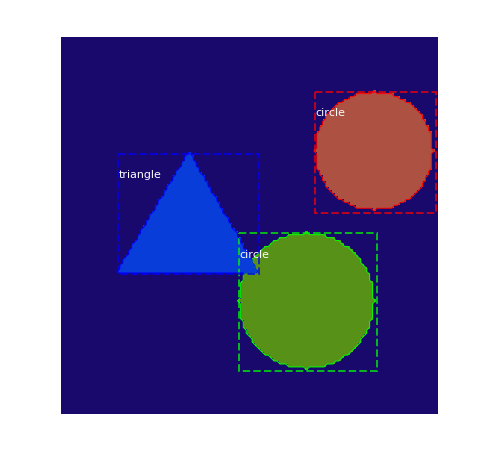

In [12]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:    9.00000  max:  179.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -107.80000  max:   75.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


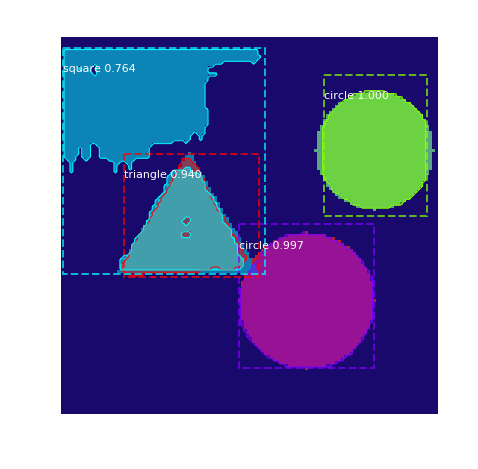

In [13]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [14]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.95
